In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

# FDR RDM for select gameweeks

In [3]:
complete_fdr_df = pd.read_csv('FDR_23-24.csv')
complete_fdr_df

,Team,GW1,GW2,GW3,GW4,GW5,GW6,GW7,GW8,GW9,...,GW29,GW30,GW31,GW32,GW33,GW34,GW35,GW36,GW37,GW38
0,ARS,2,2,2,4,2,3,2,5,3,...,3,5,2,3,3,2,3,2,3,2
1,AVL,4,2,2,4,2,3,3,2,3,...,2,2,5,3,4,2,3,3,4,2
2,BOU,3,4,3,3,3,3,4,2,2,...,2,2,2,2,4,3,3,4,3,3
3,BRE,3,2,2,2,4,2,2,3,2,...,2,4,3,3,2,2,2,2,2,4
4,BHA,2,2,3,4,3,2,3,4,5,...,5,4,3,4,2,3,2,3,4,4
5,BUR,5,2,3,3,2,4,4,3,3,...,3,3,2,2,3,2,3,4,3,2
6,CHE,4,2,2,2,2,3,2,2,4,...,4,2,4,2,2,3,3,3,2,2
7,CRY,2,4,3,2,3,2,3,2,4,...,4,2,2,5,4,3,2,4,2,3
8,EVE,2,3,2,2,4,3,2,2,4,...,4,2,4,2,3,2,3,2,2,4
9,FUL,2,3,4,5,2,2,3,2,3,...,3,2,2,4,2,4,2,3,5,2


## Select the teams and gws you want to look at 

In [4]:
def select_gw_team_subset(complete_fdr_df, gw_start=1, gw_end=38, teams='All'):

    '''
    Function to select a subset of the FDR dataframe based on the gameweeks and teams you want to look at.
    
    Parameters:
    - complete_fdr_df: DataFrame containing the fixture difficulty rating (FDR) data.
    - gw_start: The starting gameweek (inclusive).
    - gw_end: The ending gameweek (inclusive).
    - teams: A list of teams you want to look at. Default is 'All', which selects all teams.
    
    Returns:
    - A DataFrame subset based on the specified gameweeks and teams.
    '''

    # GW subset, inclusive
    gws_subset = [f'GW{i}' for i in range(gw_start, gw_end+1)]

    # select the teams you want to look at - input should be a list
    if teams == 'All':
        teams = complete_fdr_df['Team'].to_list()
    elif type(teams) == list:
        pass
    else:
        raise ValueError("Please input your teams in list format - ie: ['ARS', 'LIV', 'MUN']")

    fdr_df = complete_fdr_df[complete_fdr_df['Team'].isin(teams)][['Team'] + gws_subset]
    return fdr_df

In [5]:
# select teams you want to look at
fdr_df = select_gw_team_subset(complete_fdr_df, gw_start=10, gw_end=16, teams='All')
fdr_df

,Team,GW10,GW11,GW12,GW13,GW14,GW15,GW16
0,ARS,2,4,2,3,2,2,3
1,AVL,2,2,2,3,2,5,4
2,BOU,2,5,4,2,3,2,3
3,BRE,3,3,4,4,2,3,2
4,BHA,2,2,2,2,3,3,2
5,BUR,2,2,4,3,2,2,3
6,CHE,3,3,5,4,3,3,2
7,CRY,3,2,2,2,2,2,4
8,EVE,2,3,2,4,2,4,3
9,FUL,3,4,3,2,4,2,3


## Let's plot each team's FDR for the given GWs

Higher values = harder fixtures

In [6]:
def plot_fdr_df(fdr_df, save_dir=None):

    # Calculate the sum of the values for each team
    sums_per_team = fdr_df.set_index('Team').sum(axis=1)

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.bar(fdr_df['Team'], sums_per_team)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel('Team')
    plt.ylabel('FDR Sum')
    plt.title(f"FDR for {fdr_df.columns[1]}-{fdr_df.columns[-1]}") 
    plt.ylim(sums_per_team.min()-1, sums_per_team.max()+.5)
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir)
    plt.show()

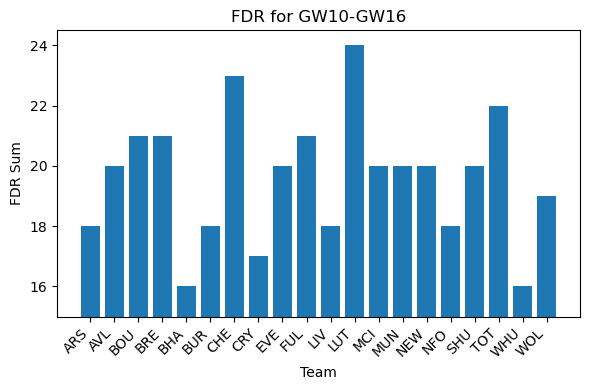

In [7]:
plot_fdr_df(fdr_df)

In this example above, we might want to avoid players from Luton Town, Spurs (TOT), and Chelsea, since they have the hardest FDR for the given gameweeks. On the other hand, we might want to consider adding players from Brighton and West Ham!

## FDR RSA

This plot allows us to see which teams have dissimilar GW difficulty scores

It is helpful for substitutions and backups - when one player has a bad fixture in a given GW, we can try to get a different player with a good fixture on that GW. 

The higher the value in the RDM, the more different the FDR for the select gameweeks. 0 values mean they have the same FDRs - ie: the diagonal compares each team to itself, so the value of the diagonal = 0. 

In [8]:
def get_and_plot_fdr_rdm(fdr_df, metric='cityblock', save_dir=None):
    '''
    Function to calculate the pairwise distances of Fixture Difficulty Ratings (FDR) and plot the Representational Dissimilarity Matrix (RDM).
    
    Parameters:
    - fdr_df: DataFrame containing the fixture difficulty rating (FDR) data.
    - metric: The distance metric to use for calculating pairwise distances. Default is 'cityblock' (Manhattan distance).
    - save_dir: The directory path to save the plotted heatmap. Default is None, which means the plot will not be saved.
    
    Returns:
    - A DataFrame of the RDM with pairwise distances.
    '''

    # Set the team names as the index
    new_df = fdr_df.set_index('Team')

    # Calculate the pairwise distances
    # Since FDR is a discrete measure, we want to use the Manhattan distance metric (it sums the absolute differences of the coordinates)
    dist_matrix = pdist(new_df, metric=metric)

    # Convert the distances to a square matrix (RDM)
    rdm = squareform(dist_matrix)

    # Convert to DataFrame for easier viewing + plotting
    fdr_rdm_df = pd.DataFrame(rdm, index=new_df.index, columns=new_df.index)
    
    # Plot the RDM using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(fdr_rdm_df, annot=True, fmt=".1f", cmap='magma', cbar_kws={'label': 'Manhattan distance'})
    plt.title(f"FDR RSM for {fdr_df.columns[1]}-{fdr_df.columns[-1]}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir)
    plt.show()

    return fdr_rdm_df

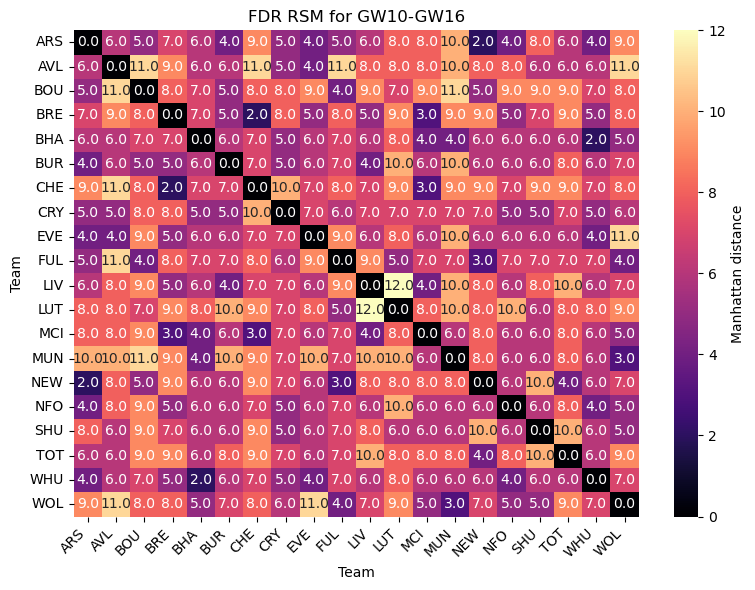

In [9]:
rdm_df = get_and_plot_fdr_rdm(fdr_df)

# Use case: Rotation Goalkeeper Selection

In FPL, a known strategy is to purchase two low cost (<4.5) keepers and rotate them out. How do we select these two keepers? 

This season (2023-24), there were a few promising keepers who cost only $4.5 or less:
- Bernd Leno (FUL)
- Jordan Pickford (EVE)
- Matt Turner (NFO)
- Lukasz Fabianski (WHU)

Let's see how we can find the best rotation of keepers based on maximally disimilar FDRs (for the first 10 GWs)!

In [10]:
# select teams you want to look at
teams = ['FUL', 'EVE', 'NFO', 'WHU']
fdr_df = select_gw_team_subset(complete_fdr_df, gw_start=1, gw_end=10, teams=teams)
fdr_df

,Team,GW1,GW2,GW3,GW4,GW5,GW6,GW7,GW8,GW9,GW10
8,EVE,2,3,2,2,4,3,2,2,4,2
9,FUL,2,3,4,5,2,2,3,2,3,3
15,NFO,4,2,3,3,2,5,3,2,2,4
18,WHU,2,3,3,2,5,4,2,4,3,2


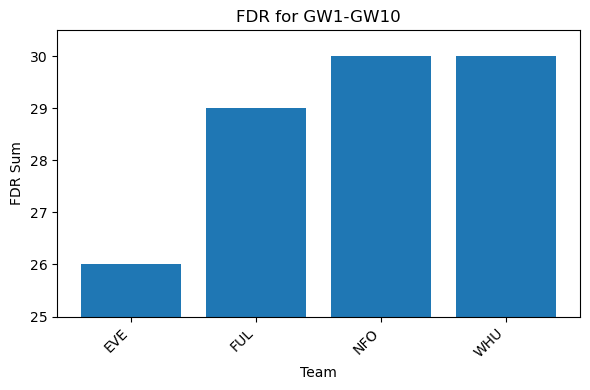

In [11]:
plot_fdr_df(fdr_df)

Given Everton's low FDR during the first 10 GWs, it looks like Pickford is a good pick! Let's see who can fill in for him during his more difficult GWs.

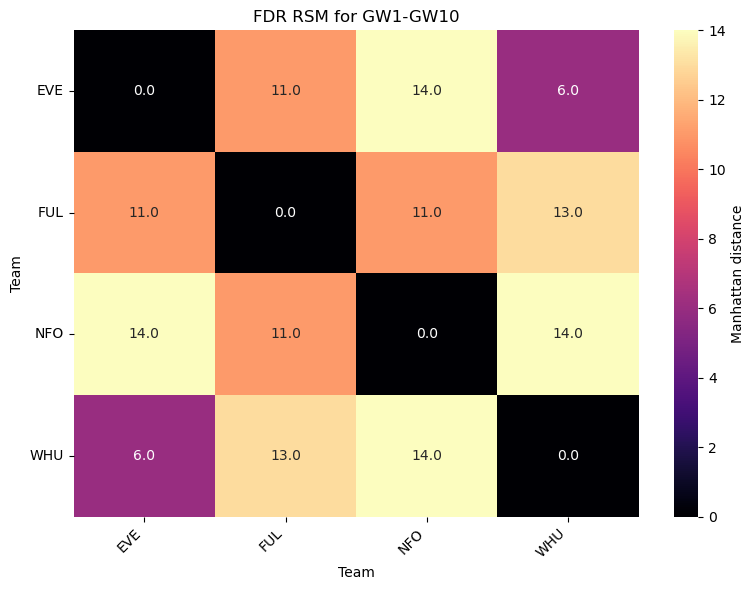

In [12]:
rdm_df = get_and_plot_fdr_rdm(fdr_df)

Based on the plot, we can see that Everton and Nottingham Forrest have the pairwise maximally distinct FDRs! When Pickford has a hard fixture (GW5 & GW9; FDR=4),  Turner has easier fixtures (FDR=2). 